# Predicting Accident Risk in Maryland
By Madhava Paliyam

CMSC 320 

Prof. Nayeem Teli


**Goal**

The end goal of this project is to create a mathematical model which will be able to create a heatmap of the risk of being in a traffic accident given the weather, day of week, and hour of day.
Although there are many factors which could affect the risk of accident, I chose to focus on time, day of week, and weather since I felt like these would be some of the most important in calculating risk. In addition, to create the heatmap, I would also need to determine which locations in Maryland would have the highest risk of accidents.


This project has the potential to be useful since it could help emergency responders focus more resources on areas with higher risk during the right time and weather conditions. It could also help determine reasons why a particular area has high number of accidents. Lastly, this can help with safe route planning. 

## Method
1. Data Collection
2. Data Processing
3. Data Exploration and Visualization
4. Model/Analysis
5. Insight/Policy


A few others have also done similar projects but with many more features. Those sources were very helpful while going through my own project. One major help was Daniel Wilson's article in Medium: https://medium.com/geoai/using-machine-learning-to-predict-car-accident-risk-4d92c91a7d57. Also, this article also in the Medium was helpful in understanding decision trees: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0. 


## Data Collection
I obtained Maryland Car Accident Data from data.gov. The data included over 400,000 accidents that had occurred in Maryland between January 2015 and March 2019. Each accident had many parameters describing it, such as latitude, longitude, weather, road type, surface conditions, etc.; however, I only imported the:
1. WEATHER_CODE (number describing the weather during the accident)
2. ACC_DATE (the date which the accident occured)
3. ACC_TIME (time of the accident)
4. LATTITUDE
5. LONGITUDE

WEATHER_CODE was described using a code which had to be found from a different file. I imported the first file as a CSV file and the second as excel spreadsheet and read them in as pandas dataframes. The output of the code below shows what the first 5 entries in the dataframe looks like. 

**Sources**

https://catalog.data.gov/dataset/maryland-statewide-vehicle-crashes

https://catalog.data.gov/dataset/maryland-statewide-vehicle-crash-data-dictionary-f4840

In [4]:
from arcgis.gis import GIS
import pandas as pd
import numpy as np
#import data as csv files from downloaded folder
#import into dataframe
all_data = pd.read_csv(r'/Users/madhavapaliyam/Documents/CMSC/cmsc320/projects/Maryland_Statewide_Vehicle_Crashes.csv')
ref = pd.read_excel(r'/Users/madhavapaliyam/Documents/CMSC/cmsc320/projects/OpenDataDictionary.xlsx')
all_data = all_data[['WEATHER_CODE','ACC_DATE','ACC_TIME','LATITUDE','LONGITUDE']]
all_data.head()

,WEATHER_CODE,ACC_DATE,ACC_TIME,LATITUDE,LONGITUDE
0,0.00,20180222,112900,39.195855,-76.747153
1,6.01,20160101,10:05:00,38.831154,-76.941169
2,3.00,20170829,183000,39.286939,-76.630100
3,7.01,20190117,120000,38.837275,-76.868940
4,6.01,20161008,013500,39.000433,-76.892639


## Data Processing
1. Fix the time format to make conversion to datetime format easier. 
2. Loop through each entry and convert the weather code to an actual weather
    1. Precipitation: Rain, Snow, Wintry Mix, etc.
    2. Clear   
    3. Cloudy
3. Convert dates and times into condensed datetime format
4. Fix columns to include the new data from data processing. 
5. Drop rows in data which did not have weather data or did not have time/data information. 

In [5]:
import time
import datetime
from time import mktime
from datetime import datetime
#Replace the colons in the data with empty strings to make converting to datetime easier
ACCIDENT_TIME = []
all_data['ACC_TIME'].replace(regex=True,inplace=True,to_replace=r':',value=r'')
all_data.head()

,WEATHER_CODE,ACC_DATE,ACC_TIME,LATITUDE,LONGITUDE
0,0.00,20180222,112900,39.195855,-76.747153
1,6.01,20160101,100500,38.831154,-76.941169
2,3.00,20170829,183000,39.286939,-76.630100
3,7.01,20190117,120000,38.837275,-76.868940
4,6.01,20161008,013500,39.000433,-76.892639


In [6]:
WEATHER = []
#convert the weather code into strings using the values obtained from the other dataframe
#convert the date into datetime format
#if data does not have date append NaN
for entry in all_data.iterrows():
    if entry[1].WEATHER_CODE == 6.01:
        WEATHER.append('Clear')
    elif entry[1].WEATHER_CODE == 7.01:
        WEATHER.append('Cloudy')
    elif entry[1].WEATHER_CODE == 0.00 or entry[1].WEATHER_CODE == 88.00 or entry[1].WEATHER_CODE == 99.00:
        WEATHER.append(np.nan)   
    else:
        WEATHER.append('Precipitation')
    try:
        ACCIDENT_TIME.append(datetime.strptime(str(entry[1].ACC_DATE)+' '+str(entry[1].ACC_TIME),'%Y%m%d %H%M%S'))
    except:
        ACCIDENT_TIME.append(np.nan)
        continue

In [7]:
len(WEATHER) == len(all_data)

True

In [8]:
len(ACCIDENT_TIME) == len(all_data)

True

In [9]:
len(all_data)

484358

In [10]:
#drop values that are not needed
all_data.drop(['ACC_DATE','ACC_TIME','WEATHER_CODE'], inplace = True, axis=1)
all_data['ACC_DATETIME'] = ACCIDENT_TIME
all_data['WEATHER'] = WEATHER
all_data.head()


,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER
0,39.195855,-76.747153,2018-02-22 11:29:00,NaN
1,38.831154,-76.941169,2016-01-01 10:05:00,Clear
2,39.286939,-76.630100,2017-08-29 18:30:00,Precipitation
3,38.837275,-76.868940,2019-01-17 12:00:00,Cloudy
4,39.000433,-76.892639,2016-10-08 01:35:00,Clear


In [11]:
all_data.isna().sum() 

LATITUDE            0
LONGITUDE           0
ACC_DATETIME     1155
WEATHER         55614
dtype: int64

In [12]:
#Drop NaN values since they do not have time or weather data
all_data = all_data.dropna()
len(all_data)

428169

## Data Exploration and Visualization
1. I used argis library to visualize coordinate data for accidents. 
2. I obtained a random sample of 5000 data points from the data set and plotted them using arcgis. 

Source and Documentation: https://developers.arcgis.com/python/

In [13]:
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureCollection
import random

In [14]:
#obtain a random sample of 5000 data points
whole_sample = all_data.sample(n=5000, replace=False)
hour = []
#get the hour of each of the data points and add it as another column
for entry in whole_sample.iterrows():
    hour.append(entry[1]['ACC_DATETIME'].hour)
whole_sample['HOUR'] = hour
#split data into rush hour and not rush hour data
rush_hour = whole_sample[(whole_sample.HOUR >= 6) & (whole_sample.HOUR < 9) | (whole_sample.HOUR >= 16) & (whole_sample.HOUR < 19)] 
not_rush = whole_sample[(whole_sample.HOUR < 6) | ((whole_sample.HOUR >= 9) & (whole_sample.HOUR < 16)) | (whole_sample.HOUR >= 19)] 



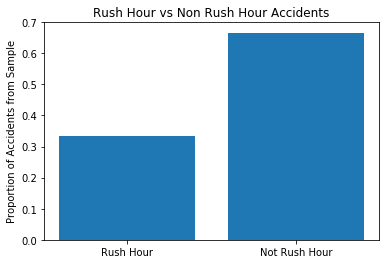

In [16]:
import matplotlib.pyplot as plt
plt.bar(['Rush Hour','Not Rush Hour'],[len(rush_hour)/len(whole_sample),len(not_rush)/len(whole_sample)])
plt.title('Rush Hour vs Non Rush Hour Accidents')
plt.ylabel('Proportion of Accidents from Sample')
plt.show()

**About 33% of accidents occured during rush hour which was from 6 am to 9 am, and 4 pm to 7 pm, meaning that rush hour was defenitely a more risky time to be on the road.**

## Whole Sample Plot:
**The whole 5000 accident sample was plotted. There was heavy clustering around the beltway for both Baltimore and Washington DC. I also noticed the high density of accidents occuring in downtown Baltimore.**

In [17]:
#connection to arcgis free account 
gis = GIS("https://www.arcgis.com", username="mangomadhava", password="")
#create a maryland map with dark theme
md_crash = gis.map("Maryland",7.5)
md_crash.basemap = 'streets-night-vector'
#import the data from the dataframes before into the map and plot it 
crash_coord1 = gis.content.import_data(whole_sample[0:999])
crash_coord2 = gis.content.import_data(whole_sample[1000:1999])
crash_coord3 = gis.content.import_data(whole_sample[2000:2999])
crash_coord4 = gis.content.import_data(whole_sample[3000:3999])
crash_coord5 = gis.content.import_data(whole_sample[4000:4999])
md_crash.add_layer(crash_coord1)
md_crash.add_layer(crash_coord2)
md_crash.add_layer(crash_coord3)
md_crash.add_layer(crash_coord4)
md_crash.add_layer(crash_coord5)
#center the map
md_crash.center = [38.9, -77]
md_crash.zoom = 7
md_crash

MapView(layout=Layout(height='400px', width='100%'), zoom=7.0)

## Rush Hour Plot:
**Out of the 5000 samples, 1671 accidents occured during rush hour. In this plot, there was not a noticable difference in terms of location of the accidents when compared with the previous plot.**

In [18]:
#new map for rush hour plot
rush = gis.map("Maryland",7.5)
rush.basemap = 'streets-night-vector'
#divide the data into 5 sections and plot them using .add_layer function 
fifth = int(len(rush_hour)/5)
crash_coord1 = gis.content.import_data(rush_hour[0:fifth - 1])
crash_coord2 = gis.content.import_data(rush_hour[fifth:2*fifth - 1])
crash_coord3 = gis.content.import_data(rush_hour[2*fifth:3*fifth - 1])
crash_coord4 = gis.content.import_data(rush_hour[3*fifth:4*fifth - 1])
crash_coord5 = gis.content.import_data(rush_hour[4*fifth:5*fifth - 1])
rush.add_layer(crash_coord1)
rush.add_layer(crash_coord2)
rush.add_layer(crash_coord3)
rush.add_layer(crash_coord4)
rush.add_layer(crash_coord5)
#center the graph and display
rush.center = [38.9, -77]
rush.zoom = 7
print(len(rush_hour))
rush



1669


MapView(layout=Layout(height='400px', width='100%'), zoom=7.0)

## Non-Rush Hour Plot:
**Out of the 5000 samples, 3329 did not occur during rush hour. In this plot as well there was no noticable difference compared with the other plots.**

In [19]:
#make new graph for non rush hour data
non_rush = gis.map("Maryland",7.5)
non_rush.basemap = 'streets-night-vector'
#partition data intofifths and plot using .add_layer()
fifth = int(len(not_rush)/5)
crash_coord1 = gis.content.import_data(not_rush[0:fifth - 1])
crash_coord2 = gis.content.import_data(not_rush[fifth:2*fifth - 1])
crash_coord3 = gis.content.import_data(not_rush[2*fifth:3*fifth - 1])
crash_coord4 = gis.content.import_data(not_rush[3*fifth:4*fifth - 1])
crash_coord5 = gis.content.import_data(not_rush[4*fifth:5*fifth - 1])
non_rush.add_layer(crash_coord1)
non_rush.add_layer(crash_coord2)
non_rush.add_layer(crash_coord3)
non_rush.add_layer(crash_coord4)
non_rush.add_layer(crash_coord5)
#center the graph and display
non_rush.center = [38.9, -77]
non_rush.zoom = 7
print(len(not_rush))
non_rush

3331


MapView(layout=Layout(height='400px', width='100%'), zoom=7.0)

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

## Week and Time Plot:
The plot below shows the distribution of accidents based on time of day and day of week. All 400,000 accidents are used to make this plot. The X axis shows the day of week followed by the hour of the day. The days of the week start with Monday = 0, and Sunday = 6 and the hours are in 24 hour time. The Y axis shows the number of accidents out of the 400,000 accident sample that occured during any given time. The day of the week weights for the data are also calculated at this time but will be used later during machine learning. 

From the graph it can be observed that each peak in accidents on weekdays occur during the morning and evining rush hours with the evining rush hour being the most dangerous. Also, weekends are generally safer with not nearly as many accidents. Lastly, small patterns can be observed such as Friday evining rush hour starting earlier and having a slightly different shape than the other weekdays, which could be because people want to get home earlier for the weekend.

ACC_DATETIME
0    0.875393
1    0.924952
2    0.904274
3    0.932776
4    1.000000
5    0.874135
6    0.742421
Name: ACC_DATETIME, dtype: float64

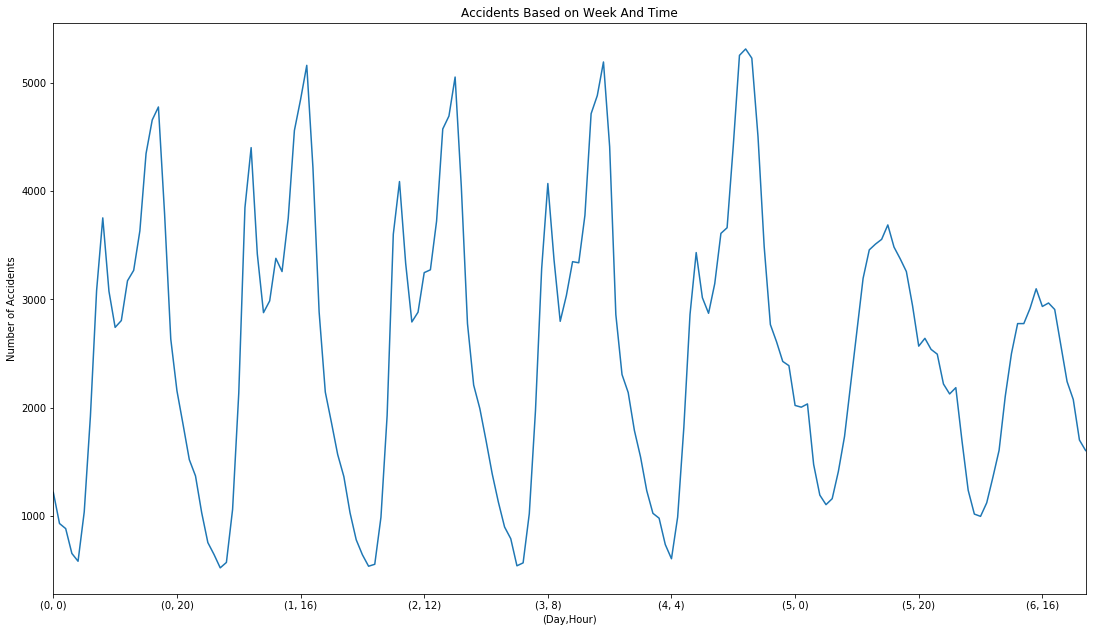

In [121]:
#create plots and set size to 18.5 by 10.5
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
day_graph = all_data['ACC_DATETIME']
#group the data by weekday and hour and plot using line graph 
ax = day_graph.groupby([day_graph.dt.weekday, day_graph.dt.hour]).count().plot(kind="line",title="Accidents Based on Week And Time")
#calculate the effect of day of the week on accidents - to be used later as a weight
week_effect = day_graph.groupby([day_graph.dt.weekday]).count()
ax.set_xlabel("(Day,Hour)")
ax.set_ylabel("Number of Accidents")
week_effect = week_effect/np.max(week_effect)


## Day Plot:
The plot below shows the time of accidents from the 400000 accident sample. Similar to the previous plot, there are peaks around 8 am to 9 am and from 3 pm to 5 pm. Day weights are also calculated to be used later for machine learning.

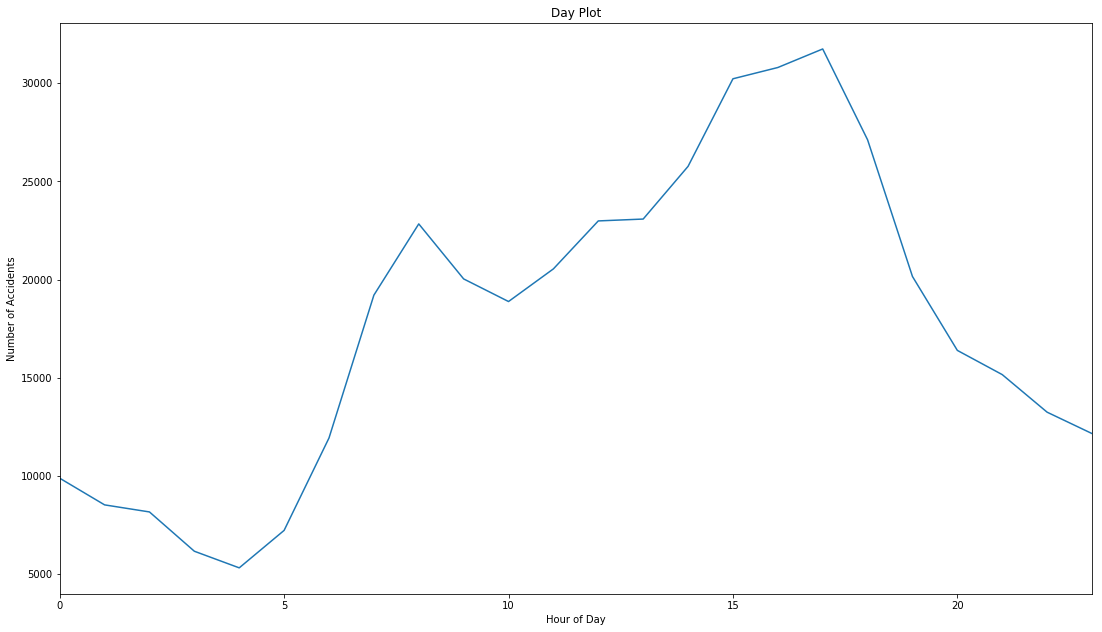

In [153]:
#create subplots and set figure size
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
day_graph = all_data['ACC_DATETIME']
#group by sum on hour and plot as a line plot
ax = day_graph.groupby([day_graph.dt.hour]).count().plot(kind="line",title="Day Plot")
#calculate the effect of day on accidents to be used later
day_effect = day_graph.groupby([day_graph.dt.hour]).count()
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Accidents')
day_effect = day_effect/np.max(day_effect)

## Weather Plot:
The plot below shows the weather conditions during accidents from the cleaned dataset. The data shows that about 71% of the accidents happened during Clear days, while 9% were during Cloudy days, and 18% were during days with Precipitation. An overwhelming majority of accidents happened during Clear days. 


Total Data: 427664

WEATHER
Clear            306887
Cloudy            41251
Precipitation     79526
Name: WEATHER, dtype: int64


WEATHER
Clear            0.717589
Cloudy           0.096457
Precipitation    0.185954
Name: WEATHER, dtype: float64
WEATHER
Clear            1.000000
Cloudy           0.134418
Precipitation    0.259138
Name: WEATHER, dtype: float64


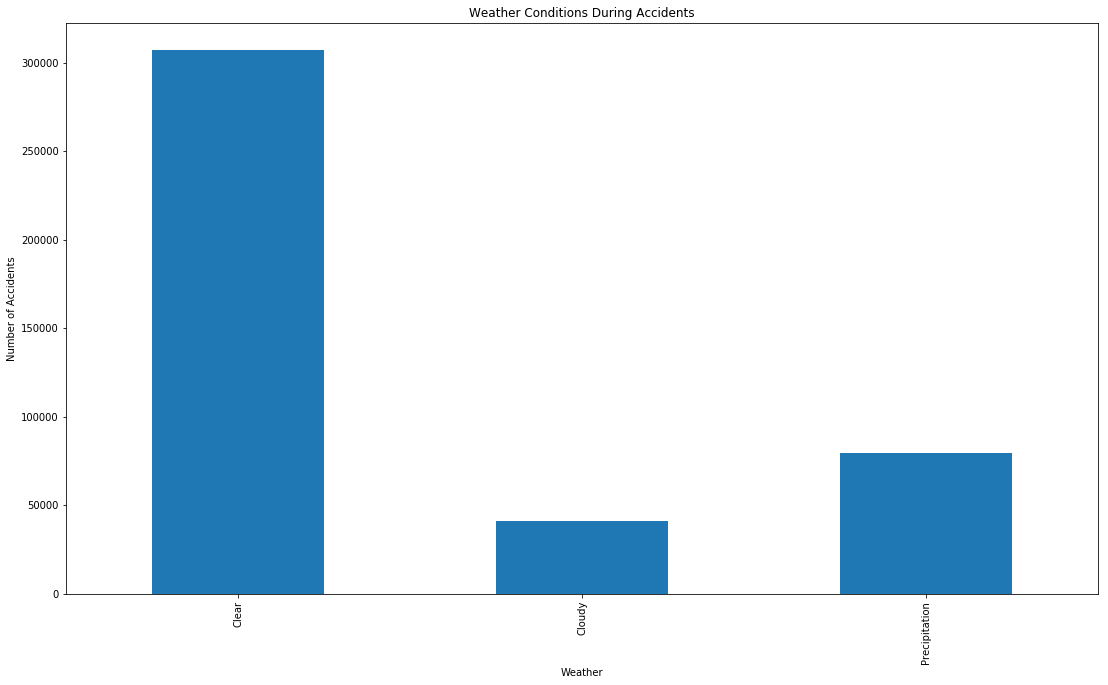

In [143]:
#create subplots and set figure size
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
day_graph = pd.Series(all_data['WEATHER'])
#group by sum of weather and plot 
g = day_graph.groupby([day_graph]).count().plot(kind="bar",title = "Weather Conditions During Accidents")
g.set_xlabel('Weather')
g.set_ylabel('Number of Accidents')
#display the percentages and numerical values for each weather 
print('\nTotal Data: ' + str(len(all_data)) + '\n')
print(day_graph.groupby([day_graph]).count())
print('\n')
print(day_graph.groupby([day_graph]).count()/len(all_data))
#calculate weather weights to be used later 
weather_weights = day_graph.groupby([day_graph]).count()/np.max(day_graph.groupby([day_graph]).count())


## Error Plot of Weather:
Since the weather data favored clear days a lot, I decided to do some research to determine the number of days that were clear, cloudy, or had precipitation. Using College Park, MD as a central point between the cold and mountanious west and warmer east side of the state, I found there to be about 55% of clear days, 14% of cloudy days, and 31% rainy days on average. 

Sources: 

https://weatherspark.com/y/21781/Average-Weather-in-College-Park-Maryland-United-States-Year-Round

https://www.bestplaces.net/climate/state/maryland

Expected = $$\begin{bmatrix}.55 \\ .14 \\ .31\end{bmatrix} x 427664$$

Error = $$\frac{Actual - Expected}{Expected}$$

Text(0.5, 1.0, 'Weather Error')

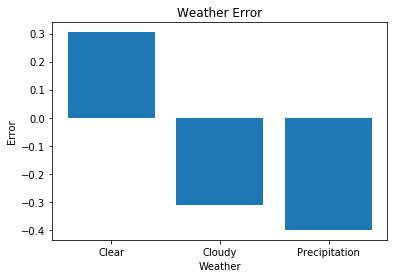

In [24]:
day_graph = pd.Series(all_data['WEATHER'])
day_graph.groupby([day_graph]).size()
#Expected proportion of clear, cloudy, and precipitation days
expected = pd.Series([.55,.14,.31],index=['Clear','Cloudy','Precipitation'])
#Multiply times the size of dataframe to get numerical estimates
expected = expected * len(day_graph)
#calculate error
dif = day_graph.groupby([day_graph]).count() - expected
dif = dif/expected
#display on plot
dif.index.name = 'Actual - Expected'
plt.bar(dif.index, dif)
plt.xlabel('Weather')
plt.ylabel('Error')
plt.title('Weather Error')

In [ ]:
min_date = all_data['ACC_DATETIME'].min()
max_date = all_data['ACC_DATETIME'].max()
print(min_date)
print(max_date)



In [27]:
import plotly.plotly as py
import plotly.graph_objs as go
#Create arrays to create heatmap
conditions = ['Clear','Cloudy','Precipitation']
#date represents each hour of the week
date_list = list(range(0,168)) 
cloudy = [0 for row in range(168)]
precip = [0 for row in range(168)]
clear = [0 for row in range(168)]
day_of_week = []
hour_of_day = []

#for each entry add the proper weather data to the list 
for entry in all_data.iterrows():
    hour = entry[1]['ACC_DATETIME'].hour
    day = entry[1]['ACC_DATETIME'].weekday()
    day_of_week.append(day)
    hour_of_day.append(hour)
    weather = entry[1]['WEATHER']
    #determine hour of the week
    correct_pos = (day * 24) + hour 
    #based on the weather add one to the value for the heatmap
    if weather == 'Clear':
        clear[correct_pos] = clear[correct_pos] + 1
    elif weather == 'Precipitation':
        precip[correct_pos] = precip[correct_pos] + 1
    else:
        cloudy[correct_pos] = cloudy[correct_pos] + 1
    
    

## Weather Based Heatmap:
The plot below shows the number of accidents over a week. The X axis shows the hours in a week ranging from 0, which is Monday at 12 am to 167 Sunday at 11 pm. The Y axis shows the different weather types and the shaded color is the number of accidents that occur at a given X and Y. As shown in the graph, there is a higher number of accidents occuring during rush hour of each weekday and the pattern repeats for each weather type. 

The heatmap also shows a much lower risk of accident during days with Precipitation and Clouds. One reason could be that our intuition is to think that rain = more accidents, since there is usually more traffic. However, people drive slower and less in the rain and therefore could mean less accidents. Clear days on the other hand cause people to be confident and drive much less carefully which could lead to more accidents. 

Source and Documentation: https://plot.ly/#/

In [173]:
import plotly as py
import plotly.plotly as ppp
#create heatmap using plotly go.Heatmap function which takes in three arrays corresponding to the x,y,z axis
two_d = np.stack((clear,cloudy,precip), axis=0)
trace = go.Heatmap(z=two_d,x=date_list,y=conditions)
data=[trace]
py.tools.set_credentials_file(username='mangomadhava', api_key='')
ppp.iplot(data, filename='labelled-heatmap')



In [152]:
#this function creates a heatmap of the trace that is passed in and overlays that on top of an image of Maryland
#the opacity can be controlled by a slider 
def make_heatmap(heat_map):
    layout= go.Layout(images= [dict(
                  source= "https://cdn2.bigcommerce.com/n-pktq5q/jz0ukb45/product_images/uploaded_images/maryland-states-lights-web.png",
                  xref= "x",
                  yref= "y",
                  x= -.5,
                  y= len(heat_map.y) - .5, #scaling from latitude to y
        #2.5+1,
                  sizex= len(heat_map.x),  #scaling from longitude to x
        #5+2,
                  sizey= len(heat_map.y),
        #3+1,
                  sizing= "stretch",
                  opacity= 0.5,
                  layer= "above")])
    fig=go.Figure(data=[heat_map],layout=layout)
    ig = fig
    #creates the dictionary needed for the plot 
    axis = dict(
        autorange = True,
        tickmode = None,
        showticklabels = False,
        title = '',
        ticks = ''
    )
    steps = []
    #creates the slider and sets opacity 
    for i in range(100):
        step = dict(
            method = 'relayout',
            args = ['images[0].opacity', float(i)/100.0],
            label = str( float(i)/100.0 )
        )
        steps.append(step)

    sliders = [dict(
        active = 50,
        currentvalue = {"prefix": "Alpha: "},
        y = 1.5,
        len = 0.5,
    
        pad = {"t": 0},
        steps = steps
    )]

    ig['layout']['sliders'] = sliders
    ig['layout']['xaxis'] = axis
    ig['layout']['yaxis'] = axis
    #plots the heatmap, displays it, and returns it to the caller
    ppp.iplot(ig)
    return ig





In [30]:
all_data.head()

,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER
1,38.831154,-76.941169,2016-01-01 10:05:00,Clear
2,39.286939,-76.630100,2017-08-29 18:30:00,Precipitation
3,38.837275,-76.868940,2019-01-17 12:00:00,Cloudy
4,39.000433,-76.892639,2016-10-08 01:35:00,Clear
5,39.203210,-76.861939,2015-04-08 13:14:00,Precipitation


In [31]:
import math
#function for converting latitude to cell values
def tLat(lat):
    return 60 - round((39.7211 - lat)/.0321993125) - 1
#function for converting longitude to cell values
def tLong(long):
    return round((long - -79.47002)/0.0299042268) + 4 - 2
#tests
print(tLat(38.837275))
print(tLong(-76.868940))


32
89


In [32]:
#transforms the all_data dataframe by applying the functions defined above to add two new columns 
all_data['FUNC_LAT'] = all_data['LATITUDE'].apply(lambda x: tLat(x))
all_data['FUNC_LONG'] = all_data['LONGITUDE'].apply(lambda x: tLong(x))
all_data.head()


,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER,FUNC_LAT,FUNC_LONG
1,38.831154,-76.941169,2016-01-01 10:05:00,Clear,31,87
2,39.286939,-76.630100,2017-08-29 18:30:00,Precipitation,46,97
3,38.837275,-76.868940,2019-01-17 12:00:00,Cloudy,32,89
4,39.000433,-76.892639,2016-10-08 01:35:00,Clear,37,88
5,39.203210,-76.861939,2015-04-08 13:14:00,Precipitation,43,89


In [33]:
#removing extraneous data such as accidents which were not in MD which are in MD database for some reason 
all_data = all_data[all_data.FUNC_LAT < 65]
all_data = all_data[all_data.FUNC_LAT >= 0]
all_data = all_data[all_data.FUNC_LONG >= 0]
all_data = all_data[all_data.FUNC_LONG < 150]
all_data.head()

,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER,FUNC_LAT,FUNC_LONG
1,38.831154,-76.941169,2016-01-01 10:05:00,Clear,31,87
2,39.286939,-76.630100,2017-08-29 18:30:00,Precipitation,46,97
3,38.837275,-76.868940,2019-01-17 12:00:00,Cloudy,32,89
4,39.000433,-76.892639,2016-10-08 01:35:00,Clear,37,88
5,39.203210,-76.861939,2015-04-08 13:14:00,Precipitation,43,89


In [35]:
#creates a new heatmap of all the accidents in Maryland
test_x = ['^-^'+str(i) for i in range(150)]
test_y = list(range(0,65))
test_z = [[0 for i in range(150)] for j in range(65)]
#for each row the z value is updated for the corresponding cell 
for entry in all_data.iterrows():
    entry_lat = entry[1]['FUNC_LAT']
    entry_long = entry[1]['FUNC_LONG']
    test_z[entry_lat][entry_long] = test_z[entry_lat][entry_long] + 1


## Heatmap of accidents in Maryland using whole data set:
The heatmap below was created by finding an image from the internet of Maryland and overlaying a heatmap on top of it with a slidebar to vary opacity. Coordinates had to be scaled to fit within the 150 x 65 grid that I decided on. The scaling factor and conversion was done through the method above called make_heatmap. The plot is made by using the package plotly.  

The heatmap shows the number of accidents in a given cell of the 150x65 heatmap. Some interesting features of the plot shown by increasing the transparency show a map of the major roadways in the Baltimore-Washington Corridor. In addition, the DC beltway still shows a high number of accidents and the highest number of accidents occurr in the Baltimore downtown region. 

In [174]:
#creates a trace using the three arrays defined above 
test_trace = go.Heatmap(z=test_z,x=test_x,y=test_y,opacity=.8)
#plots the trace 
ppp.iplot(make_heatmap(test_trace))

In [144]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#function for obtaining training data for machine learning in proper format
def get_train_data(x):
    #gets a random sample of x values without replacement
    samp = all_data.sample(n=x, replace=False)
    samp_x = ['^-^'+str(i) for i in range(150)]
    samp_y = list(range(0,65))
    samp_z = [[0 for i in range(150)] for j in range(65)]
    risk = []
    #first sets the sample z values to the number of accidents that occur in each cell in the sample
    for entry in samp.iterrows():
        entry_lat = entry[1]['FUNC_LAT']
        entry_long = entry[1]['FUNC_LONG']
        samp_z[entry_lat][entry_long] = samp_z[entry_lat][entry_long] + 1
    #maximum value of accidents in the sample
    max_value = np.amax(samp_z)
    for i in range(len(samp_z)):
        for j in range(len(samp_z[1])):
            #sets the value in the cell equal to the proportion of accidents as compared to the max cell
            #ex. cell with high number of accidents will be around .8 or .9 while low will be around .1 or .2
            val = (samp_z[i][j]/max_value)#*100
            samp_z[i][j] = val
            #if there are no accidents happen in the cell 
            if val == 0:
                #make new accident based on random values and weather probabilites from prior
                w = np.random.random()
                if w < .55:
                    new_w = 'Clear'
                elif w < (.55 + .14):
                    new_w = 'Cloudy'
                else: 
                    new_w = 'Precipitation'
                #append sample into data set as negative sample
                samp = samp.append({'LATITUDE':(39.7211-((59-i)*.0321993125)),'LONGITUDE': (((j-2)*0.0299042268)-79.47002),'WEATHER': new_w, 'FUNC_LAT':i,'FUNC_LONG':j,'RISK':0},ignore_index=True)
    samp['ACC_DATETIME'] = pd.to_datetime(samp['ACC_DATETIME'])
    #obtain the day of week and hour of day data 
    for index, row in samp.iterrows():
        if row['ACC_DATETIME'] < datetime.now():
            samp.loc[index,'DAY_OF_WEEK'] = row['ACC_DATETIME'].weekday()
            samp.loc[index,'HOUR_OF_DAY'] = row['ACC_DATETIME'].hour
        else: 
            #if sample does not have - a negative sample - choose randomly
            samp.loc[index,'DAY_OF_WEEK'] = random.randint(0,6)
            samp.loc[index,'HOUR_OF_DAY'] = random.randint(0,23)
        if row['RISK'] != 0:
            entry_lat = row['FUNC_LAT']
            entry_long = row['FUNC_LONG']
            #calculate risk using the equation described above
            samp.loc[index,'RISK'] = (samp_z[entry_lat][entry_long])*(week_effect[samp.loc[index,'ACC_DATETIME'].weekday()])*(day_effect[samp.loc[index,'ACC_DATETIME'].hour])*(weather_weights[samp.loc[index,'WEATHER']])
    #one hot encode weather data
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(samp['WEATHER'])
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot = np.array(onehot_encoded)
    samp['CLEAR'] = onehot[:,0]
    samp['CLOUDY'] = onehot[:,1]
    samp['PRECIPITATION'] = onehot[:,2]
    #one hot encode day of the week data
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = np.array(samp['DAY_OF_WEEK'])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot = np.array(onehot_encoded)
    for i in range(7):
        samp['DAY_'+str(i)] = onehot[:,i]
    #one hot encode hour of day data  
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = np.array(samp['HOUR_OF_DAY'])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot = np.array(onehot_encoded)
    for i in range(24):
        samp['HOUR_'+str(i)] = onehot[:,i]
    #create trace and return both sample and trace    
    samp_trace = go.Heatmap(z=samp_z,x=samp_x,y=samp_y,opacity=.8)      
    return samp_trace,samp



## Determining Risk: 
The risk associated with each accident data point will need to take into account the weather during the accident, the location of the accident, the time of day and day of week the accident occured. The calculation of risk was as follows: 

$$Risk = \frac{CellAccidents}{MaxAccidents}\cdot weatherWeight \cdot hourWeight \cdot dayWeight$$

Where: 

CellAccidents = the number of accidents occuring in the cell the accident is located in. 

MaxAccidents = the maximum number of accidents that occur in any cell of the heatmap. 

$$weatherWeight = \frac{AccidentsForWeather}{MaxAccidentsForWeather}$$

$$hourWeight = \frac{AccidentsForGivenHour}{MaxAccidentsHour}$$

$$dayWeight = \frac{AccidentsForDay}{MaxAccidentsDay}$$

For example: Cloudy days weight would equal $\frac{NumberOfAccidentsCloudy}{NumberOfAccidentsClear}$ since the maximum of accidents in the weather category occurred on Clear days. 




This was repeated for each accident data point and added to the dataframe as a column called 'RISK'. The risk will be used as the output for the machine learning algorithm to train on. The risk will change based on all the parameters that I have chosen. 

In [151]:
#get data for plot
train = get_train_data(10000)
plot_data = train[0]
training_data = train[1]


/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a La

## Obtaining Negative Data
So far for each accident data point there is location data, time data, and weather data and a risk associated with it.

However, these are all positive examples of accidents and while training a model it is important that I have negative data as well, meaning data about accidents that did not happen. To obtain this I changed all the cells in the heatmap that did not have any accidents in them into data points and added them to the dataframe with 0 risk. I chose the weather based on the weather data that I had found earlier, but day and time were chosen randomly. 



## One Hot Encoding Categorical Data
Categorical variables in my data set include weather, day of the week, and hour of day. Since these are not continuous in my dataset, they have to be one hot encoded into my dataset. 

Before and after One hot encoding: 


$$\begin{bmatrix}Accident Number & Weather\\ 0 & Clear \\ 1 & Clear\\ 2 & Cloudy \\ 3 & Precipitation \end{bmatrix}
    \Longrightarrow \begin{bmatrix} Accident Number & Clear & Cloud & Precipitation \\
                                0 & 1 & 0 & 0\\
                                1 & 1 & 0 & 0\\
                                2 & 0 & 1 & 0\\
                                3 & 0 & 0 & 1 \end{bmatrix}$$

This was repeated for day of week, hour of day, and weather in the dataframe and is shown below.


In [155]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
training_data.head()


,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER,FUNC_LAT,FUNC_LONG,RISK,DAY_OF_WEEK,HOUR_OF_DAY,CLEAR,CLOUDY,PRECIPITATION,DAY_0,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,HOUR_0,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,HOUR_7,HOUR_8,HOUR_9,HOUR_10,HOUR_11,HOUR_12,HOUR_13,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,39.163707,-76.814686,2019-03-14 08:16:00,Clear,42,91,0.060261,3.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38.815151,-76.997509,2015-08-07 10:21:00,Cloudy,31,85,0.008814,4.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39.094914,-77.113971,2015-08-11 13:30:00,Clear,40,81,0.030201,1.0,13.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.999155,-76.983216,2016-04-19 16:30:00,Clear,37,85,0.227108,1.0,16.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39.285524,-76.587434,2016-04-15 18:40:00,Clear,45,98,0.139482,4.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [156]:
training_data.tail()

,LATITUDE,LONGITUDE,ACC_DATETIME,WEATHER,FUNC_LAT,FUNC_LONG,RISK,DAY_OF_WEEK,HOUR_OF_DAY,CLEAR,CLOUDY,PRECIPITATION,DAY_0,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,HOUR_0,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,HOUR_7,HOUR_8,HOUR_9,HOUR_10,HOUR_11,HOUR_12,HOUR_13,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
18380,39.882097,-75.193716,NaT,Clear,64,145,0.0,2.0,23.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18381,39.882097,-75.163811,NaT,Clear,64,146,0.0,3.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18382,39.882097,-75.133907,NaT,Precipitation,64,147,0.0,6.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18383,39.882097,-75.104003,NaT,Clear,64,148,0.0,2.0,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18384,39.882097,-75.074099,NaT,Precipitation,64,149,0.0,1.0,11.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Parameter Corellation with Number of Accidents
The plots shown below describe corellation between each variable in the dataframe and the number of accidents. 

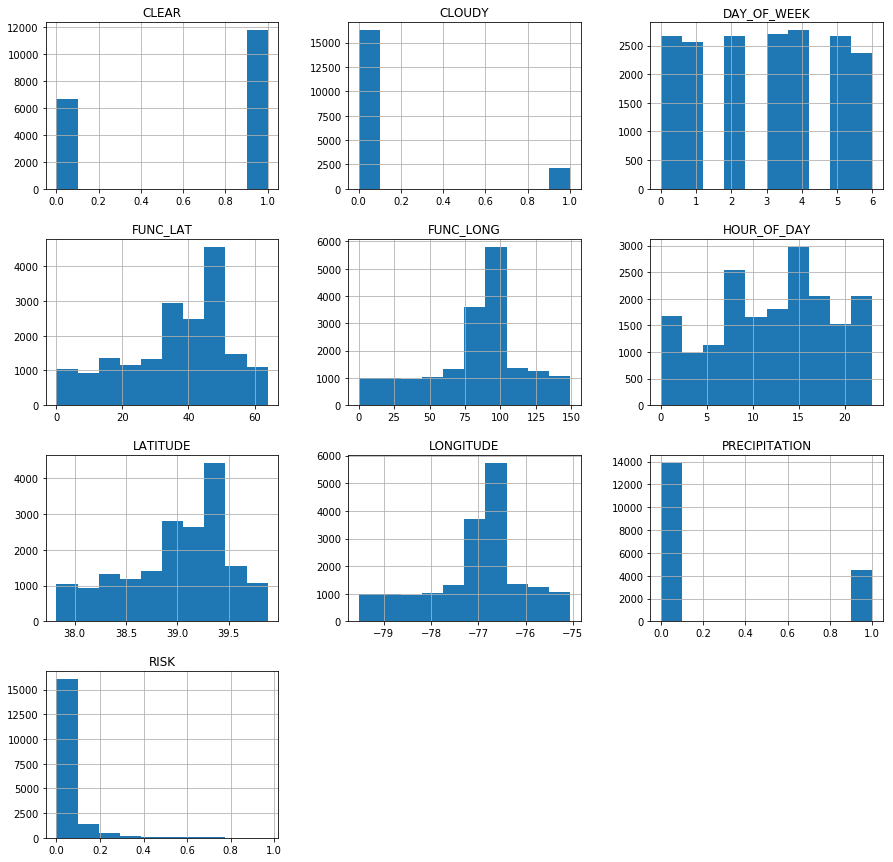

In [157]:
#drop unnessasary columns and create plot 
training_data.drop(['HOUR_0','HOUR_1','HOUR_2','HOUR_3','HOUR_4','HOUR_1','HOUR_5','HOUR_6','HOUR_7','HOUR_8','HOUR_9','HOUR_10','HOUR_11','HOUR_12','HOUR_13','HOUR_14','HOUR_15','HOUR_16','HOUR_17','HOUR_18','HOUR_19','HOUR_20','HOUR_21','HOUR_22','HOUR_23','DAY_0','DAY_1','DAY_2','DAY_3','DAY_4','DAY_5','DAY_6'],axis=1).hist(figsize = (15,15))
plt.show()

## Corellation Matrix
The plot below shows the corellation between each variable with every other variable. By looking at the data, risk does not have many positively or negatively corellated variables as shown by the pink. This means that linear regression would not be the best fit for predicting values in this dataset. 

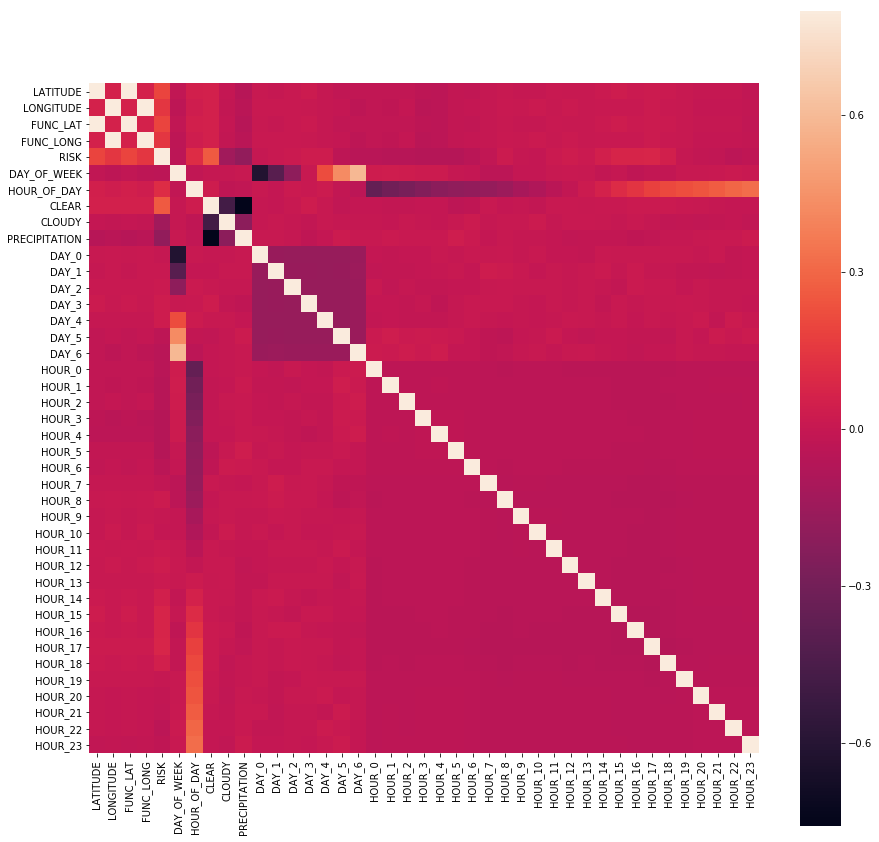

In [158]:
import seaborn as sb
#use seaborn to create a corralation matrix
C_mat = training_data.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf



## Machine Learning Model 
I decided on using a decision tree regressor as my model to predict values for the cells in the heatmap. The overall flow of the model is described below: 

**Split Data Into 66% - Training, 7% Validation, And 27% Test** 

**Use Test Data to Train Model**

**Validate Using Validation Data**

**Test accuracy on Test Data**

**Use Model on Each Cell of 150x65 matrix**

**Use Matrix To Make Heatmap**




In [109]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
#this method will run and return a random forest regressor method given the training data and depth parameter
def run_tree(size,train_data):
    training = train_data
    outputs = training['RISK']
    training = training.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1)
    reg = RandomForestRegressor(n_estimators = 100, max_depth = size)
    #MLPRegressor(hidden_layer_sizes=(size),  activation='logistic', solver='adam', alpha=0.001,batch_size=200,
     #          learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
      #         random_state=None, tol=0.0001, verbose=True, warm_start=False, momentum=0.9,
       #        nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
        #       epsilon=1e-08)
    reg = reg.fit(training, outputs)
    return reg






In [110]:
#this function will validate data by predicting the values on the validation data and returns the difference 
def validate(validation_data, model):
    v = model.predict(validation_data.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
    return np.subtract(validation_data['RISK'],v)


In [111]:
#this method runs, validates, and plots a random forest regressor given training data, size and an index for plotting
#it also plots the residuals of the validation data
def run_validate_plot(train, validate_data, size,i):
    model = run_tree(size,train)
    plt.figure(i)
    plt.hist(validate(validate_data,model))
    plt.title(str(size))
    return model

## Obtain Data: 
First, I obtain data using the get_train_data function that I had defined earlier. This returns the data properly formatted and also calculates the risks with each of the data points. I choose to use 150,000 data points and use 100,000 for training, 10,000 for validation, and 40,000 for test. The data is chosen as a random sample without replacement. 

In [145]:
#obtains 150,000 samples from the get_train_data function
#splits the data into seperate parts
train_data = get_train_data(150000)[1]
validation = train_data.iloc[100000:110000]
test_dataa = train_data.iloc[110000:149999]
train_data = train_data.iloc[0:100000]

/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a La

## Training and Validation: 
I made 6 models with varying number of depths and check its loss against the validation data set. 

**Training:**

The model is trained using a random forest regressor using bootstrapping. Bootstrapping is when a random sample is chosen from the dataset with replacement and trained on. A random forest is made up of decision trees, and example of one of the decision trees from the model can be seen if you scroll down. Many such decision trees are made and the results from each are pooled together to determine the result of the test. The For more information on how exactly a decision tree works this article in the Medium is very informative: https://medium.com/greyatom/decision-trees-a-simple-way-to-visualize-a-decision-dc506a403aeb.

The depth of the trees were as follows: 
1. model1 = 200
2. model2 = 50
3. model3 = 20
4. model4 = 10
5. model5 = 5
6. model6 = 3

**Validation and Testing**

After a model is trained, it is validated against the validation data. The errors are plotted below. 

$$ValidationPlot = \begin{bmatrix} Predicted Risk\end{bmatrix} - \begin{bmatrix} Validation Risk\end{bmatrix}$$

$$Mean Absolute Error = \frac{\sum_{i=1}^{n}|\begin{bmatrix} Predicted Risk\end{bmatrix} - \begin{bmatrix} Actual Risk\end{bmatrix}|}{n}$$

I chose to use model1 in my actual tests because of the low error. 


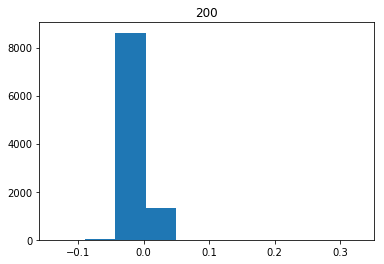

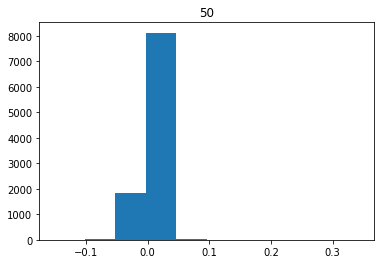

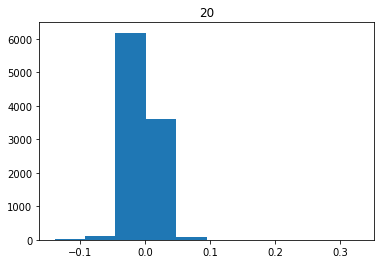

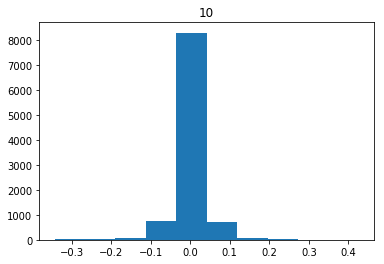

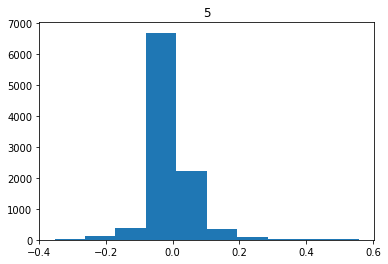

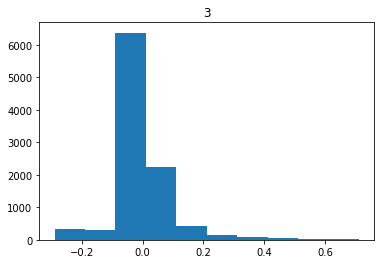

In [169]:
#runs 6 models with varying depths 
model1 = run_validate_plot(train_data,validation,200,1)
model2 = run_validate_plot(train_data,validation,50,2)
model3 = run_validate_plot(train_data,validation,20,3)
model4 = run_validate_plot(train_data,validation,10,4)
model5 = run_validate_plot(train_data,validation,5,5)
model6 = run_validate_plot(train_data,validation,3,6)



In [170]:
#calculates the accuracy of the model using the test data for each model
t1 = model1.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t1))
print('Mean Absolute Error for 200 trees:', round(np.mean(errors), 4))

t2 = model2.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t2))
print('Mean Absolute Error for 50 trees:', round(np.mean(errors), 4))

t3 = model3.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t3))
print('Mean Absolute Error for 20 trees:', round(np.mean(errors), 4))

t4 = model4.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t4))
print('Mean Absolute Error for 10 trees:', round(np.mean(errors), 4))

t5 = model5.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t5))
print('Mean Absolute Error for 5 trees:', round(np.mean(errors), 4))

t6 = model6.predict(test_dataa.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'], axis=1))
errors = np.abs(np.subtract(test_dataa['RISK'],t6))
print('Mean Absolute Error for 3 trees:', round(np.mean(errors), 4))

Mean Absolute Error for 200 trees: 0.0036
Mean Absolute Error for 50 trees: 0.0036
Mean Absolute Error for 20 trees: 0.0079
Mean Absolute Error for 10 trees: 0.0218
Mean Absolute Error for 5 trees: 0.0392
Mean Absolute Error for 3 trees: 0.0557


## Example of A Small Decison Tree: 
This tree is part of one of the trees in the random forest that I trained. It has a depth of 3 layers. As shown below, the machine learns these parameters and decisions to make using a Greedy Algorithm for selecting parameters. In summary, the best split is made by the algorithm using an entropy function. The split which has the highest information gain is made and the algorithm moves on to the next layer or node. To learn more about how decision trees are created the following link is very helpful: https://www.saedsayad.com/decision_tree.htm. 

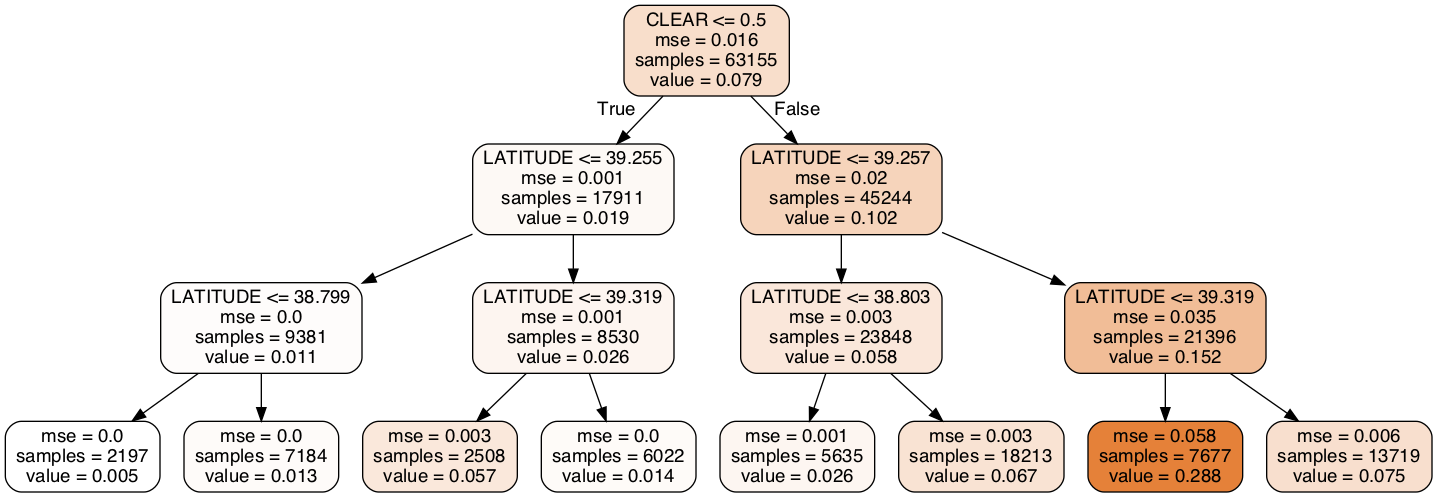

In [150]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
import pydotplus
#exports the tree and displays the tree in the jupyter notebook window
treeD = model6.estimators_[5]
all_features = ['LATITUDE','LONGITUDE','CLEAR','CLOUDY','PRECIPITATION','DAY_0','DAY_1','DAY_2','DAY_3','DAY_4','DAY_5','DAY_6','HOUR_0','HOUR_1','HOUR_2','HOUR_3','HOUR_4','HOUR_5','HOUR_6','HOUR_7','HOUR_8','HOUR_9','HOUR_10','HOUR_11','HOUR_12','HOUR_13','HOUR_14','HOUR_15','HOUR_16','HOUR_17','HOUR_18','HOUR_19','HOUR_20','HOUR_21','HOUR_22','HOUR_23']
dot_data = tree.export_graphviz(treeD, out_file=None, feature_names=all_features,filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


## Feature Importance:
Each split on the decision tree was based on a feature. However, some of the features were not as important for determining the risk and the importance of each feature is shown below. Latitude and longitude are the most important, followed by Clear weather, and 3-5pm rush hour. 

In [168]:
#uses the paramters in the model to obtain feature importance and display it using standard python formatting
importances = list(model1.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(all_features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: LATITUDE             Importance: 0.4732
Variable: LONGITUDE            Importance: 0.289
Variable: CLEAR                Importance: 0.0867
Variable: HOUR_17              Importance: 0.0243
Variable: HOUR_16              Importance: 0.0218
Variable: HOUR_15              Importance: 0.0216
Variable: HOUR_18              Importance: 0.012
Variable: HOUR_14              Importance: 0.0109
Variable: DAY_6                Importance: 0.0062
Variable: HOUR_8               Importance: 0.0047
Variable: HOUR_12              Importance: 0.0047
Variable: HOUR_13              Importance: 0.0046
Variable: HOUR_2               Importance: 0.0038
Variable: HOUR_3               Importance: 0.0029
Variable: HOUR_0               Importance: 0.0028
Variable: HOUR_1               Importance: 0.0027
Variable: HOUR_4               Importance: 0.0025
Variable: DAY_4                Importance: 0.0022
Variable: HOUR_23              Importance: 0.0022
Variable: HOUR_5               Importance: 0.0021
Va

In [87]:
#this function will create a heatmap of Maryland on top of risks given a model and parameters
#this can be used to predict risk on a particular day and time 
def make_model_heatmap(weather, model, day, hour):
    samp_x = ['^-^'+str(i) for i in range(150)]
    samp_y = list(range(0,65))
    samp_z = [[0 for i in range(150)] for j in range(65)]
    val = training_data.iloc[0]
    val = val.drop(['FUNC_LAT', 'FUNC_LONG', 'RISK','ACC_DATETIME','WEATHER','DAY_OF_WEEK','HOUR_OF_DAY'])
    for col in val:
        val.values[:] = 0
    val[weather] = 1
    val[day] = 1
    val[hour] = 1
    for i in range(len(samp_z)):
        for j in range(len(samp_z[1])):
            temp = val
            temp['LATITUDE'] = (39.7211-((59-i)*.0321993125))
            temp['LONGITUDE'] = (((j-2)*0.0299042268)-79.47002)
            temp = np.array(val).reshape(1,-1)
            samp_z[i][j] = model.predict(temp)[0]
    heat_map = go.Heatmap(z=samp_z,x=samp_x,y=samp_y,opacity=.8)
    return heat_map

## Generating Heatmap
The make_model_heatmap method creates a heatmap of Maryland using the weather, day of the week, and hour of day passed as parameters. The risks for each cell are chosen based on the parameters that are passed to the fuction and a heatmap is returned. 

There are a few errors in the data, there are a few lines of moderate risk in the middle of the heatmap. However, for the most part, the data seems to look accurate. If the DAY_4(Friday) is changed to DAY_5(Saturday) and HOUR_15(3pm) is changed to 3, then the maximum risk shown by the scale on the left will be reduced. 

In [180]:
#generates a heatmap by calling the method above
heat_map = make_model_heatmap('CLEAR', model1, 'DAY_4', 'HOUR_15')
#display the heatmap
ppp.iplot(make_heatmap(heat_map))

/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [176]:
#generates a heatmap by calling the method above
heat_map = make_model_heatmap('CLEAR', model1, 'DAY_5', 'HOUR_3')
#display the heatmap
ppp.iplot(make_heatmap(heat_map))

/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Future Work: 
1. Train without using latitude and longitude since my data tends to rely on that a lot. 
2. Use more variables like highway speed, conjestion, population density, buissness, etc. 
3. Help model be more applicable to other places.
4. Do more research into machine learning algorithms to determine best one and tune it properly. 
5. Instead of only applying weights for day of the week and hour, look into monthly and holiday accident trends. 